# Project: AI Generated Images vs Real Images

[source] (https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images)


In [5]:
# Importing necessary libraries

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split , Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryAccuracy
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [13]:
# Path to the dataset
path = '/Users/roz.sabir/Documents/Adesso/defect_detection/tutorials/data' 

In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the path to your dataset
path = path
img_size = 28
transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),  # Resize the images to a fixed size
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Load the dataset
data = datasets.ImageFolder(root=path, transform=transform)

In [15]:
# Create an ImageFolder object
data = datasets.ImageFolder(root=path)

# Extract labels from the dataset
images, labels = zip(*data.samples)

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the label counts
print("Label Counts:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Label Counts:
Label 0: 539 samples
Label 1: 434 samples


Tensor image shape: torch.Size([3, 256, 256])


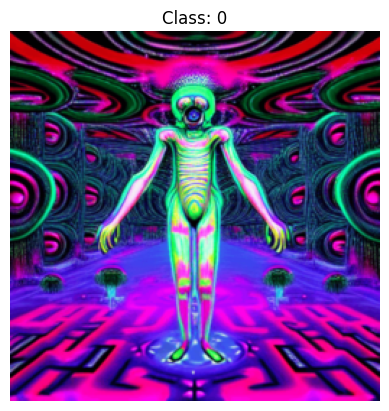

In [17]:
# Define path to your image folder
path = path
img_size = 256

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),  # Resize the images to a fixed size
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Create an ImageFolder object
data = datasets.ImageFolder(root=path, transform=transform)

# Select an image index to display
image_index = 234

# Access an image and its corresponding label
image, label = data[image_index]

# Print the shape of the tensor image
print("Tensor image shape:", image.shape)

# Convert the tensor image to a PIL image
image_pil = transforms.ToPILImage()(image)

# Display the image along with its label
plt.imshow(image_pil)
plt.title(f"Class: {label}")
plt.axis('off')
plt.show()

# class 0 is generated by AI
# class 1 is real art

In [18]:
# Create an ImageFolder object
data = datasets.ImageFolder(root=path)

# Extract labels from the dataset
images, labels = zip(*data.samples)

# Perform stratified splitting
train_images, test_images, train_labels, test_labels = train_test_split(images, labels,
                                                                        test_size=0.2,
                                                                        stratify=labels)

In [19]:
# Zip train images with train labels and create DataFrame
train_data_df = pd.DataFrame({'images': train_images, 'labels': train_labels})

# Zip test images with test labels and create DataFrame
test_data_df = pd.DataFrame({'images': test_images, 'labels': test_labels})


class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        
        # Convert image to tensor
        image = self.transform(image)
        
        # Ensure image has three channels (RGB)
        if image.shape[0] == 1:  # If grayscale, convert to RGB
            image = image.expand(3, -1, -1)  # Expand grayscale to three channels
        elif image.shape[0] == 4:  # If RGBA, remove alpha channel
            image = image[:3]  # Remove alpha channel
        
        label = self.dataframe.iloc[idx, 1]
        
        return image, label

In [24]:
img_size = 100
    
# Assuming transform is defined elsewhere
train_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
#     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

test_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])
    
# Create custom datasets for train and test sets
train_dataset = CustomImageDataset(train_data_df, transform=train_transform)
test_dataset = CustomImageDataset(test_data_df, transform=test_transform)

In [25]:
train_dataset[0][0].shape , train_dataset[0][1]

(torch.Size([3, 100, 100]), 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '0')

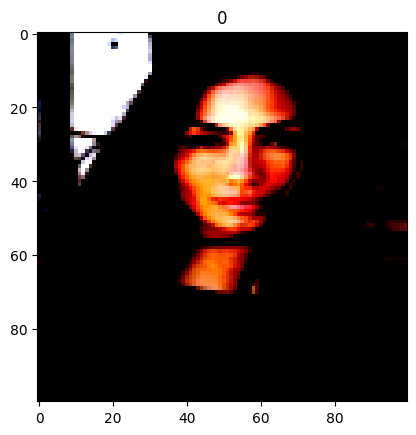

In [26]:
plt.imshow(train_dataset[4][0].permute(1,2,0))
plt.title(train_dataset[0][1])

In [27]:
print("Train Dataset:")
for i in range(5):  # Print the first 5 samples
    sample = train_dataset[i]
    print("Sample", i+1, " - Image shape:", sample[0].shape, " - Label:", sample[1])

# Print samples from test dataset
print("\nTest Dataset:")
for i in range(5):  # Print the first 5 samples
    sample = test_dataset[i]
    print("Sample", i+1, " - Image shape:", sample[0].shape, " - Label:", sample[1])

Train Dataset:
Sample 1  - Image shape: torch.Size([3, 100, 100])  - Label: 0
Sample 2  - Image shape: torch.Size([3, 100, 100])  - Label: 1
Sample 3  - Image shape: torch.Size([3, 100, 100])  - Label: 0
Sample 4  - Image shape: torch.Size([3, 100, 100])  - Label: 0
Sample 5  - Image shape: torch.Size([3, 100, 100])  - Label: 1

Test Dataset:
Sample 1  - Image shape: torch.Size([3, 100, 100])  - Label: 0
Sample 2  - Image shape: torch.Size([3, 100, 100])  - Label: 1
Sample 3  - Image shape: torch.Size([3, 100, 100])  - Label: 1
Sample 4  - Image shape: torch.Size([3, 100, 100])  - Label: 0
Sample 5  - Image shape: torch.Size([3, 100, 100])  - Label: 1


In [28]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [29]:
num_train_batches = len(train_loader)

# Calculate the number of batches in test_loader
num_test_batches = len(test_loader)

# Print the counts
print("Number of batches in train_loader:", num_train_batches)
print("Number of batches in test_loader:", num_test_batches)

Number of batches in train_loader: 25
Number of batches in test_loader: 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


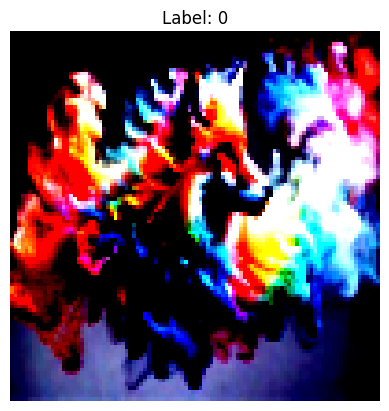

In [30]:
i, f = next(iter(train_loader))

# Extracting the first image from the batch
image = i[0]
label = f[0]

# Plotting the image
plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for displaying with matplotlib
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [31]:
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}: {images.shape}")

Batch 1: torch.Size([32, 3, 100, 100])
Batch 2: torch.Size([32, 3, 100, 100])
Batch 3: torch.Size([32, 3, 100, 100])
Batch 4: torch.Size([32, 3, 100, 100])
Batch 5: torch.Size([32, 3, 100, 100])
Batch 6: torch.Size([32, 3, 100, 100])
Batch 7: torch.Size([32, 3, 100, 100])
Batch 8: torch.Size([32, 3, 100, 100])
Batch 9: torch.Size([32, 3, 100, 100])
Batch 10: torch.Size([32, 3, 100, 100])
Batch 11: torch.Size([32, 3, 100, 100])
Batch 12: torch.Size([32, 3, 100, 100])
Batch 13: torch.Size([32, 3, 100, 100])
Batch 14: torch.Size([32, 3, 100, 100])
Batch 15: torch.Size([32, 3, 100, 100])
Batch 16: torch.Size([32, 3, 100, 100])
Batch 17: torch.Size([32, 3, 100, 100])
Batch 18: torch.Size([32, 3, 100, 100])
Batch 19: torch.Size([32, 3, 100, 100])
Batch 20: torch.Size([32, 3, 100, 100])
Batch 21: torch.Size([32, 3, 100, 100])
Batch 22: torch.Size([32, 3, 100, 100])
Batch 23: torch.Size([32, 3, 100, 100])
Batch 24: torch.Size([32, 3, 100, 100])
Batch 25: torch.Size([10, 3, 100, 100])


In [35]:
# Using a pre-trained DenseNet model
# model = models.densenet121(weights = 'DEFAULT')

model = models.efficientnet_b7(weights = 'DEFAULT')


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /Users/roz.sabir/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100.0%


In [36]:
from torchinfo import summary
# We visualize our neural network before freezing the extractor layers..
summary(model, input_size = [1,3,112,112], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
       col_width = 18, 
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [1, 3, 112, 112]   [1, 1000]          --                 True
├─Sequential (features)                                      [1, 3, 112, 112]   [1, 2560, 4, 4]    --                 True
│    └─Conv2dNormActivation (0)                              [1, 3, 112, 112]   [1, 64, 56, 56]    --                 True
│    │    └─Conv2d (0)                                       [1, 3, 112, 112]   [1, 64, 56, 56]    1,728              True
│    │    └─BatchNorm2d (1)                                  [1, 64, 56, 56]    [1, 64, 56, 56]    128                True
│    │    └─SiLU (2)                                         [1, 64, 56, 56]    [1, 64, 56, 56]    --                 --
│    └─Sequential (1)                                        [1, 64, 56, 56]    [1, 32, 56, 56]    --                 True
│    │    └─M

In [37]:
# Modifying final classifier layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

In [38]:
summary(model, input_size = [1,3,112,112], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
       col_width = 18, 
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [1, 3, 112, 112]   [1, 1]             --                 True
├─Sequential (features)                                      [1, 3, 112, 112]   [1, 2560, 4, 4]    --                 True
│    └─Conv2dNormActivation (0)                              [1, 3, 112, 112]   [1, 64, 56, 56]    --                 True
│    │    └─Conv2d (0)                                       [1, 3, 112, 112]   [1, 64, 56, 56]    1,728              True
│    │    └─BatchNorm2d (1)                                  [1, 64, 56, 56]    [1, 64, 56, 56]    128                True
│    │    └─SiLU (2)                                         [1, 64, 56, 56]    [1, 64, 56, 56]    --                 --
│    └─Sequential (1)                                        [1, 64, 56, 56]    [1, 32, 56, 56]    --                 True
│    │    └─M

In [39]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [40]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.best_accuracy = None  # New attribute to track best accuracy
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss, val_accuracy):
        if self.best_loss is None or val_loss < self.best_loss:  # Update if val_loss is better
            self.best_loss = val_loss
            self.best_accuracy = val_accuracy  # Update best accuracy along with best loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
        
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"

        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs. " \
                              f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False



In [41]:
# Define EarlyStopping
early_stopping = EarlyStopping(patience = 10, min_delta = 0.0)

In [43]:
from tqdm.autonotebook import tqdm

In [44]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    accuracy_train = BinaryAccuracy(threshold = 0.5).to(device)
    
    for batch,(X,y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)
        
        y_pred = model(X).squeeze()
        loss = loss_fn(y_pred, y)
        train_loss += loss.detach().cpu().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_proba = torch.sigmoid(y_pred)
        accuracy_train.update(y_proba, y)
        
    train_accuracy = accuracy_train.compute()
    train_loss = train_loss/len(dataloader)
    

    return train_loss, train_accuracy

In [45]:
def test_step(model:torch.nn.Module, 
              dataloader:torch.utils.data.DataLoader, 
              loss_fn:torch.nn.Module):
    
    model.eval()
    
    test_loss = 0.
    accuracy_test = BinaryAccuracy(threshold = 0.5).to(device)
    
    for batch,(X,y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)
        
        y_pred = model(X).squeeze()
        
        loss = loss_fn(y_pred, y)
        test_loss += loss.detach().cpu().item()
        
        y_proba = torch.sigmoid(y_pred)
        accuracy_test.update(y_proba, y)
        
    test_accuracy = accuracy_test.compute()
    test_loss = test_loss/len(dataloader)

    return test_loss, test_accuracy